# up and running with prefect
Many types of applications can be broken down into subtasks, some of which may be resource-intensive or long-running, and which may fail at any time for multiple reasons. Being able to define tasks, chain them together, and monitor execution is a nontrivial part of any modern computational pipeline.

`prefect` is an open source workflow management library built to address this problem. The first public release of prefect, v0.2.0, was released in July of 2018. Since then the Prefect team has released on a regular cadence, adding features and addressing bugs. [prefect.io](Prefect), the company behind the `prefect` library (also known as [Prefect Core](https://www.prefect.io/core) in the official documentation), offers a cloud-based task management dashboard called [Prefect Cloud](https://www.prefect.io/cloud/) as their flagship product. By itself, the `prefect` library is [open source](https://github.com/PrefectHQ/prefect) and totally free to use. Today we'll explore some of `prefect`'s data structures by building a simple pipeline.

## what are other task management systems?
* [Apache Airflow](https://airflow.apache.org/)
* [Luigi](https://github.com/spotify/luigi)

## first steps

In this example, we'll create a simple `prefect` pipeline. We'll write _tasks_ (individual steps in an overall pipeline), create a _flow_ (a series of tasks), and visualize our task graph using `graphviz`. First we'll need to install `prefect`; we'll also need [pandas](https://pandas.pydata.org/) and [numpy](https://numpy.org/). For fake data, we'll use [scikit-learn](https://scikit-learn.org/stable/):

`pip install prefect prefect[viz] pandas numpy scikit-learn`

`prefect[viz]` is an optional extra which is only needed if you want to generate flow visualizations with `graphviz`.


## the example
Let's imagine that we have a list of shipments; these parcels need to be classified according to whether they are shippable as-is, or oversize (and therefore subject to a higher fee). First, we'll import the required libraries and generate some example data.

In [1]:
    import prefect, pandas, numpy, sklearn.datasets

In [2]:
    sizes, _ = sklearn.datasets.make_blobs(n_features=3, center_box=[10, 100])
    shipments = pandas.DataFrame(sizes, columns=['length [cm]', 'width [cm]', 'height [cm]'])

With `prefect`, the smallest components of a pipeline are called _tasks_. These are individual operations which are usually strung together to carry out loading of data, transformations, and output. `prefect` makes it simple to turn Python functions into `prefect` _tasks_ using decorators:

In [3]:
    @prefect.task
    def compute_volume(df: pandas.DataFrame):
        """Compute the volume of each shipment."""
        df = df.copy()
        df['volume [cm^3]'] = df['length [cm]']*df['width [cm]']*df['height [cm]']
        return df

    @prefect.task(nout=2)  # <-- `nout` is required if a task has more than one return value
    def split_oversize(df: pandas.DataFrame, oversize_volume: float = 125000) -> tuple[pandas.DataFrame, pandas.DataFrame]:
        """Split the dataset into a pair of datasets - one for shippable boxes, the other for oversize boxes."""
        oversize = df['volume [cm^3]'] < oversize_volume
        return df.loc[~oversize], df.loc[oversize]
    
    @prefect.task
    def compute_costs(df: pandas.DataFrame, is_oversize: bool):
        df = df.copy()
        if is_oversize:
            price_per_cc = 0.22
        else:
            price_per_cc = 0.14
        
        df['cost'] = df['volume [cm^3]']*price_per_cc
        return df
    
    @prefect.task
    def compute_total_cost(shippable: pandas.DataFrame, oversize: pandas.DataFrame) -> float:
        return shippable['cost'].sum() + oversize['cost'].sum()

Here, I've defined Python functions as I usually would for computing the volume of each parcel and for splitting the parcels into two dataframes: one group which is oversize, and one group which is not. In order to run these tasks on our data, we'll need to define the order in which they are to be run; we'll do this by chaining them together into a _flow_. A _flow_ is a grouping of tasks with a well-defined order of execution.

In [4]:
    with prefect.Flow('Shipment Flow', result=prefect.engine.results.PrefectResult()) as flow:
        shipments_with_volume = compute_volume(shipments)
        shippable, oversize = split_oversize(shipments_with_volume)
        shippable_with_cost, oversize_with_cost = compute_costs(shippable, is_oversize=False), compute_costs(oversize, is_oversize=True)
        total_cost = compute_total_cost(shippable_with_cost, oversize_with_cost)

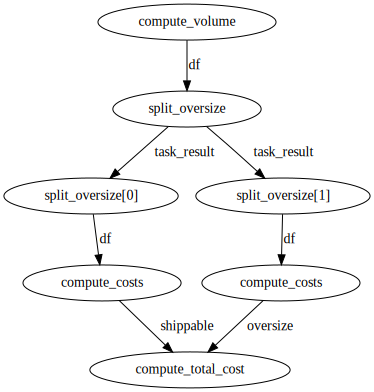

In [6]:
    flow.visualize()

Okay, the flow has been set up and we're sure the task graph looks good. Let's run it!

In [7]:
    state = flow.run()

[2021-08-09 15:50:05-0700] INFO - prefect.FlowRunner | Beginning Flow run for 'Shipment Flow'
[2021-08-09 15:50:05-0700] INFO - prefect.TaskRunner | Task 'compute_volume': Starting task run...
[2021-08-09 15:50:05-0700] INFO - prefect.TaskRunner | Task 'compute_volume': Finished task run for task with final state: 'Success'
[2021-08-09 15:50:05-0700] INFO - prefect.TaskRunner | Task 'split_oversize': Starting task run...
[2021-08-09 15:50:05-0700] INFO - prefect.TaskRunner | Task 'split_oversize': Finished task run for task with final state: 'Success'
[2021-08-09 15:50:06-0700] INFO - prefect.TaskRunner | Task 'split_oversize[0]': Starting task run...
[2021-08-09 15:50:06-0700] INFO - prefect.TaskRunner | Task 'split_oversize[0]': Finished task run for task with final state: 'Success'
[2021-08-09 15:50:06-0700] INFO - prefect.TaskRunner | Task 'split_oversize[1]': Starting task run...
[2021-08-09 15:50:06-0700] INFO - prefect.TaskRunner | Task 'split_oversize[1]': Finished task run for

Excellent, it looks like all tasks executed successfully! Next, let's look at the results. By default, `prefect` keeps track

In [8]:
    state.result

{<Task: compute_volume>: <Success: "Task run succeeded.">,
 <Task: compute_costs>: <Success: "Task run succeeded.">,
 <Task: compute_total_cost>: <Success: "Task run succeeded.">,
 <Task: split_oversize[0]>: <Success: "Task run succeeded.">,
 <Task: split_oversize[1]>: <Success: "Task run succeeded.">,
 <Task: compute_costs>: <Success: "Task run succeeded.">,
 <Task: split_oversize>: <Success: "Task run succeeded.">}

In [10]:
    state.result[total_cost].result

3499805.156768381

In [15]:
    if __name__ == "__main__":
        flow = generate_flow()
        flow.visualize()
#         import doctest
#         doctest.testmod()

## what and why should continue with `prefect`

One of the most useful features of `prefect` is its ability to generate a task graph using `graphviz`. To generate a graph,

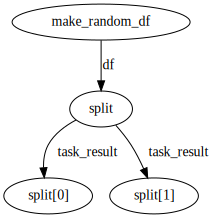

In [13]:
flow = generate_flow()
flow.visualize()

* what other problems could this solve?
Although this example is simple, it could be extended to meet the needs of a full-fledged ML pipeline.